#**Name: Muhammad Ibtihaj**
#**Reg No: SP23-BAI-037**

# **1: Regression Using ANN**

Starting training...
Epoch 10/100 | Train Loss: 1.3366 | Val Loss: 1.3104
Epoch 20/100 | Train Loss: 1.3355 | Val Loss: 1.3091
Epoch 30/100 | Train Loss: 1.3049 | Val Loss: 1.2704
Epoch 40/100 | Train Loss: 0.5850 | Val Loss: 0.5704
Epoch 50/100 | Train Loss: 0.4726 | Val Loss: 0.4520
Epoch 60/100 | Train Loss: 0.4485 | Val Loss: 0.4447
Epoch 70/100 | Train Loss: 0.4311 | Val Loss: 0.4687
Epoch 80/100 | Train Loss: 0.4163 | Val Loss: 0.5289
Epoch 90/100 | Train Loss: 0.4020 | Val Loss: 0.6264
Epoch 100/100 | Train Loss: 0.3890 | Val Loss: 0.7781


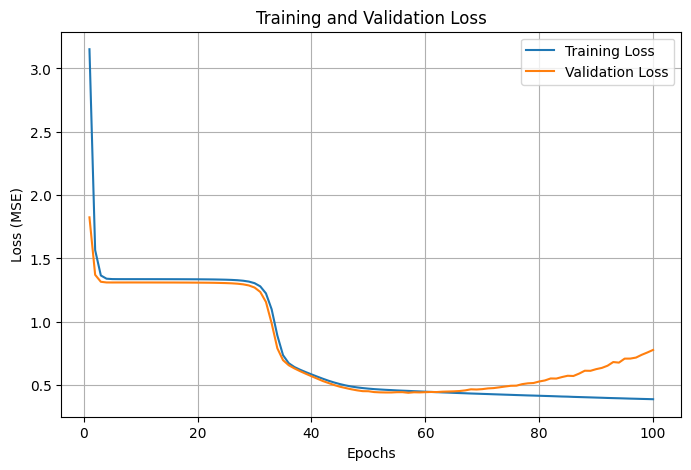

Final MSE: 0.7781
Final MAE: 0.6561
Final R²: 0.4062


In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt



class CaliforniaHousingDataset(Dataset):
    def __init__(self, X, y, scale_data=True):
        if scale_data:
            scaler = StandardScaler()
            X = scaler.fit_transform(X)
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]



X, y = datasets.fetch_california_housing(return_X_y=True)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

train_dataset = CaliforniaHousingDataset(X_train, y_train)
val_dataset = CaliforniaHousingDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)



class RegressionANN(torch.nn.Module):
    def __init__(self):
        super(RegressionANN, self).__init__()
        self.W1 = torch.nn.Parameter(torch.randn(8, 32) * 0.01)
        self.b1 = torch.nn.Parameter(torch.zeros(32))
        self.W2 = torch.nn.Parameter(torch.randn(32, 16) * 0.01)
        self.b2 = torch.nn.Parameter(torch.zeros(16))
        self.W3 = torch.nn.Parameter(torch.randn(16, 1) * 0.01)
        self.b3 = torch.nn.Parameter(torch.zeros(1))

    def forward(self, x):
        hidden1 = torch.relu(torch.mm(x, self.W1) + self.b1)
        hidden2 = torch.relu(torch.mm(hidden1, self.W2) + self.b2)
        output = torch.mm(hidden2, self.W3) + self.b3
        return output



def train_batch(data, targets, model, criterion, optimizer):
    predictions = model(data)
    loss = criterion(predictions, targets)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()



def validate_model(model, criterion, val_loader):
    model.eval()
    val_losses = []
    y_true, y_pred = [], []
    with torch.no_grad():
        for data, targets in val_loader:
            data, targets = data.float(), targets.view(-1, 1).float()
            predictions = model(data)
            val_losses.append(criterion(predictions, targets).item())
            y_true.extend(targets.numpy())
            y_pred.extend(predictions.numpy())
    return np.mean(val_losses), np.array(y_true).flatten(), np.array(y_pred).flatten()



model = RegressionANN()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-4)



n_epochs = 100
train_losses, val_losses = [], []

print("Starting training...")
for epoch in range(n_epochs):
    model.train()
    batch_losses = []
    for data, targets in train_loader:
        data, targets = data.float(), targets.view(-1, 1).float()
        loss = train_batch(data, targets, model, criterion, optimizer)
        batch_losses.append(loss)

    train_loss = np.mean(batch_losses)
    val_loss, y_true, y_pred = validate_model(model, criterion, val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{n_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")



mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mse = np.mean((y_true - y_pred) ** 2)



plt.figure(figsize=(8, 5))
plt.plot(range(1, n_epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, n_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()



print(f"Final MSE: {mse:.4f}")
print(f"Final MAE: {mae:.4f}")
print(f"Final R²: {r2:.4f}")

#**2: Classification using ANN**

Using device: cpu
Starting training...
Epoch 5/20 | Train Loss: 0.2766 | Val Loss: 0.2437
Epoch 10/20 | Train Loss: 0.1347 | Val Loss: 0.1321
Epoch 15/20 | Train Loss: 0.0893 | Val Loss: 0.1016
Epoch 20/20 | Train Loss: 0.0650 | Val Loss: 0.0876

Final Metrics:
Accuracy: 0.9732
Precision: 0.9734
Recall: 0.9732
F1 Score: 0.9732


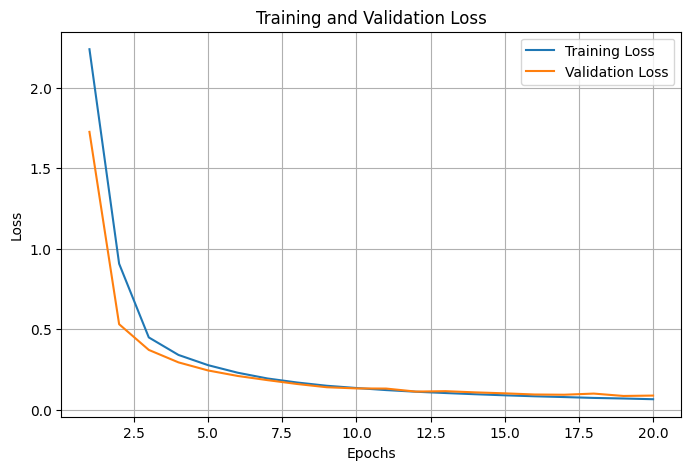

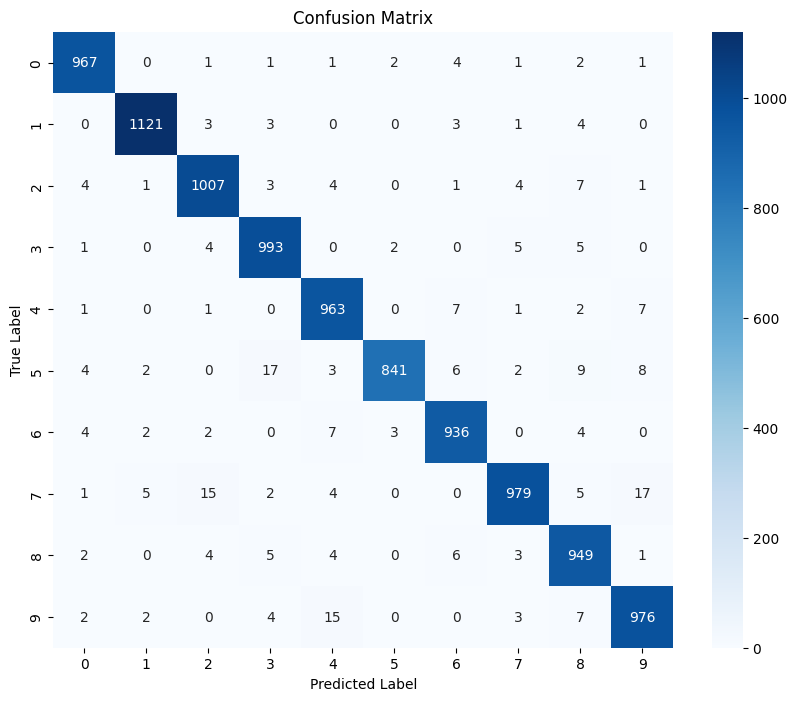

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

class ClassificationANN(torch.nn.Module):
    def __init__(self):
        super(ClassificationANN, self).__init__()
        self.W1 = torch.nn.Parameter(torch.randn(784, 128) * 0.01)
        self.b1 = torch.nn.Parameter(torch.zeros(128))
        self.W2 = torch.nn.Parameter(torch.randn(128, 64) * 0.01)
        self.b2 = torch.nn.Parameter(torch.zeros(64))
        self.W3 = torch.nn.Parameter(torch.randn(64, 10) * 0.01)
        self.b3 = torch.nn.Parameter(torch.zeros(10))

    def forward(self, x):
        x = x.view(-1, 784)
        hidden1 = torch.relu(torch.mm(x, self.W1) + self.b1)
        hidden2 = torch.relu(torch.mm(hidden1, self.W2) + self.b2)
        output = torch.mm(hidden2, self.W3) + self.b3
        return output

def train_batch(data, targets, model, criterion, optimizer):
    model.train()
    predictions = model(data)
    loss = criterion(predictions, targets)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()

def validate_model(model, criterion, test_loader):
    model.eval()
    val_losses = []
    all_preds, all_targets = [], []
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device).float(), targets.to(device).long()
            predictions = model(data)
            val_losses.append(criterion(predictions, targets).item())
            all_preds.extend(torch.argmax(predictions, axis=1).cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    return np.mean(val_losses), np.array(all_preds), np.array(all_targets)

model = ClassificationANN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

n_epochs = 20
train_losses, val_losses = [], []

print("Starting training...")
for epoch in range(n_epochs):
    model.train()
    batch_losses = []
    for data, targets in train_loader:
        data, targets = data.to(device).float(), targets.to(device).long()
        loss = train_batch(data, targets, model, criterion, optimizer)
        batch_losses.append(loss)

    train_loss = np.mean(batch_losses)
    val_loss, all_preds, all_targets = validate_model(model, criterion, test_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch + 1}/{n_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

accuracy = accuracy_score(all_targets, all_preds)
precision = precision_score(all_targets, all_preds, average='weighted')
recall = recall_score(all_targets, all_preds, average='weighted')
f1 = f1_score(all_targets, all_preds, average='weighted')

print(f"\nFinal Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(range(1, n_epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, n_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

conf_matrix = confusion_matrix(all_targets, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# **3: Classification using CNN**


Building and training Model 1...

Model 1 Summary:


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)                   │ (None, 32, 32, 2)           │              56 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 16, 16, 2)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 16, 16, 4)           │              76 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 8, 8, 4)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_14 (Flatten)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,318 (134.05 KB)

 Trainable params: 34,318 (134.05 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.3237 - loss: 1.8842 - val_accuracy: 0.4615 - val_loss: 1.5300
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - accuracy: 0.4728 - loss: 1.4818 - val_accuracy: 0.4834 - val_loss: 1.4714
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - accuracy: 0.5070 - loss: 1.3926 - val_accuracy: 0.4905 - val_loss: 1.4427
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.5383 - loss: 1.3062 - val_accuracy: 0.5200 - val_loss: 1.3686
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 43s 21ms/step - accuracy: 0.5543 - loss: 1.2608 - val_accuracy: 0.5329 - val_loss: 1.3448
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 22ms/step - accuracy: 0.5718 - loss: 1.2037 - val_accuracy: 0.5310 - val_loss: 1.3290
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - accuracy: 0.5940 - loss: 1.1579 - val_accuracy: 0.5186 - val_loss: 1.3744
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - accuracy: 0.6019 -

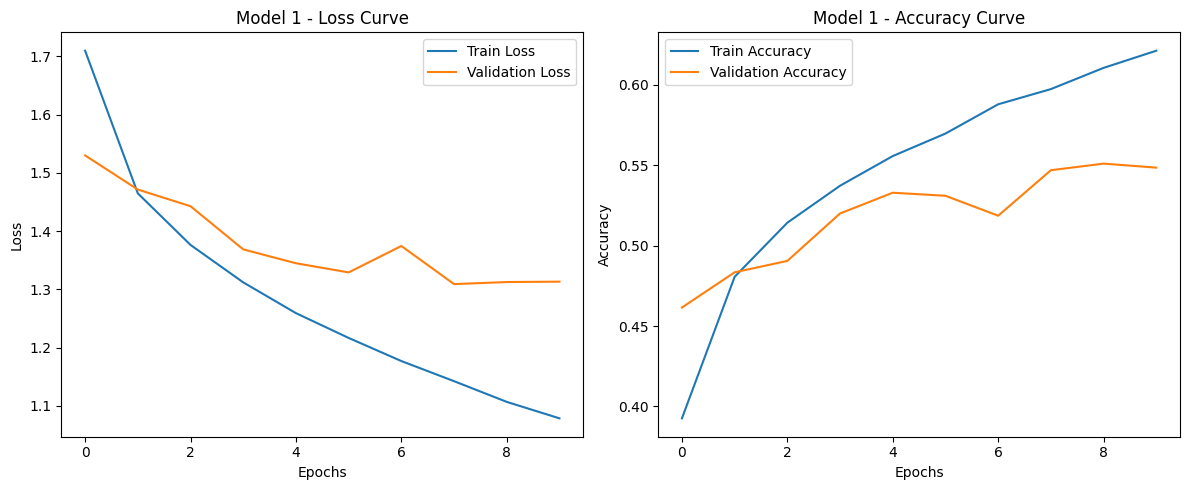


Building and training Model 2...

Model 2 Summary:


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)                   │ (None, 32, 32, 4)           │             112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 16, 16, 4)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 16, 16, 8)           │             296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 8, 8, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 8, 8, 16)            │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 4, 4, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,762 (139.70 KB)

 Trainable params: 35,762 (139.70 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.3189 - loss: 1.8688 - val_accuracy: 0.4614 - val_loss: 1.5000
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.4809 - loss: 1.4374 - val_accuracy: 0.4807 - val_loss: 1.4433
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 26ms/step - accuracy: 0.5183 - loss: 1.3448 - val_accuracy: 0.5226 - val_loss: 1.3340
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.5409 - loss: 1.2812 - val_accuracy: 0.5372 - val_loss: 1.3035
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 24ms/step - accuracy: 0.5671 - loss: 1.2260 - val_accuracy: 0.5437 - val_loss: 1.2822
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 25ms/step - accuracy: 0.5820 - loss: 1.1702 - val_accuracy: 0.5744 - val_loss: 1.2183
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5902 - loss: 1.1429 - val_accuracy: 0.5807 - val_loss: 1.1908
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.6068 -

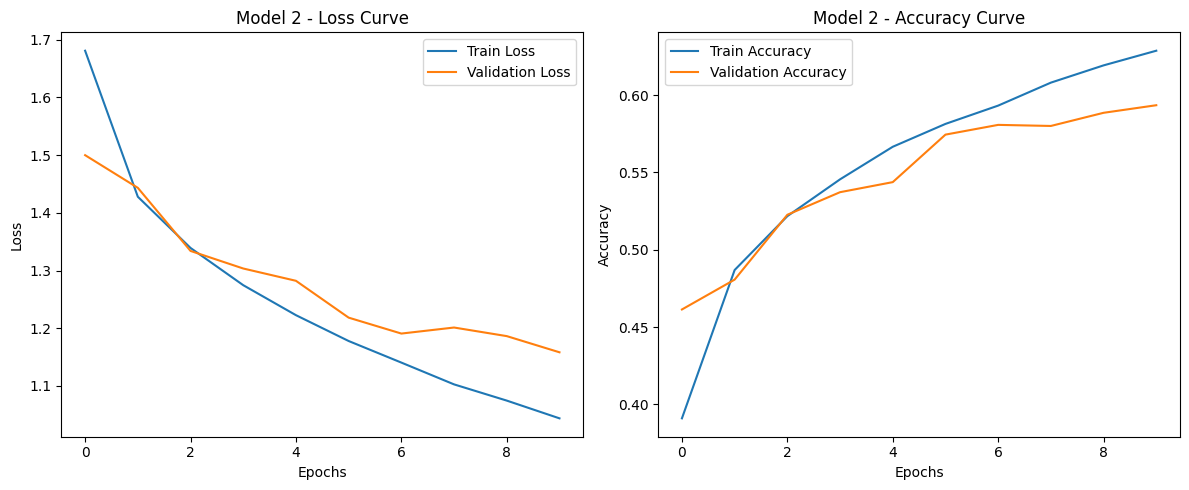


Building and training Model 3...

Model 3 Summary:


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)                   │ (None, 32, 32, 4)           │             112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 16, 16, 4)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_16 (Flatten)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 132,602 (517.98 KB)

 Trainable params: 132,602 (517.98 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - accuracy: 0.3229 - loss: 1.8761 - val_accuracy: 0.4504 - val_loss: 1.5440
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 19ms/step - accuracy: 0.4785 - loss: 1.4521 - val_accuracy: 0.4945 - val_loss: 1.4176
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 20ms/step - accuracy: 0.5213 - loss: 1.3425 - val_accuracy: 0.5169 - val_loss: 1.3639
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.5518 - loss: 1.2625 - val_accuracy: 0.5377 - val_loss: 1.3162
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.5729 - loss: 1.2127 - val_accuracy: 0.5278 - val_loss: 1.3403
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.5839 - loss: 1.1790 - val_accuracy: 0.5457 - val_loss: 1.2963
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.6045 - loss: 1.1334 - val_accuracy: 0.5600 - val_loss: 1.2659
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - accuracy: 0.6235 -

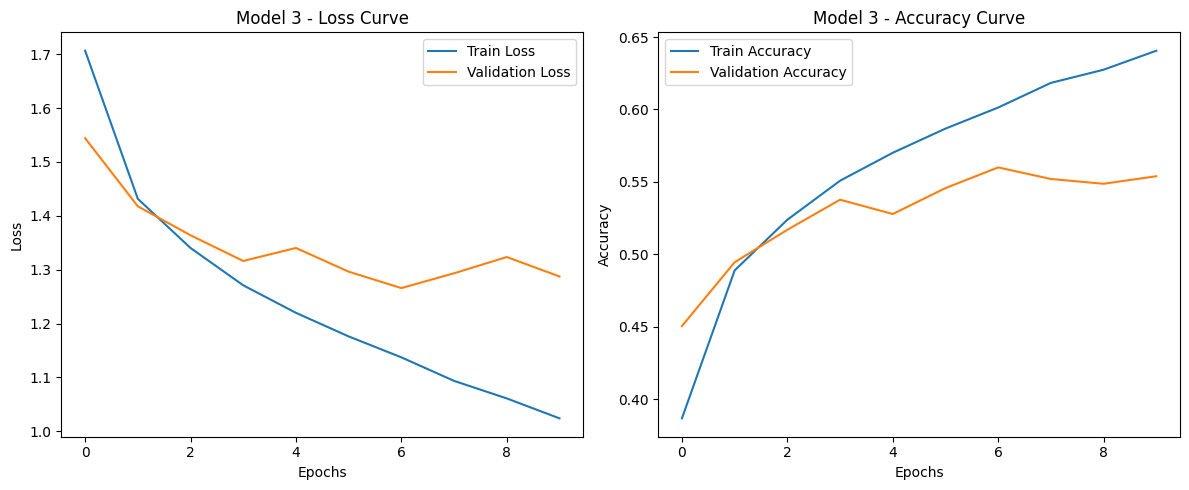


Building and training Model 4...

Model 4 Summary:


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_34 (Conv2D)                   │ (None, 32, 32, 4)           │             304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (None, 16, 16, 4)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 16, 16, 8)           │             808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_35 (MaxPooling2D)      │ (None, 8, 8, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_17 (Flatten)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,066 (265.88 KB)

 Trainable params: 68,066 (265.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 97s 43ms/step - accuracy: 0.3321 - loss: 1.8375 - val_accuracy: 0.4877 - val_loss: 1.4522
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 81s 42ms/step - accuracy: 0.5068 - loss: 1.3933 - val_accuracy: 0.5415 - val_loss: 1.3091
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 42ms/step - accuracy: 0.5521 - loss: 1.2624 - val_accuracy: 0.5551 - val_loss: 1.2712
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 43ms/step - accuracy: 0.5839 - loss: 1.1739 - val_accuracy: 0.5574 - val_loss: 1.2630
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 81s 42ms/step - accuracy: 0.6067 - loss: 1.1183 - val_accuracy: 0.5786 - val_loss: 1.2160
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 42ms/step - accuracy: 0.6300 - loss: 1.0531 - val_accuracy: 0.5849 - val_loss: 1.2053
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 43ms/step - accuracy: 0.6416 - loss: 1.0186 - val_accuracy: 0.5895 - val_loss: 1.1941
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 53s 42ms/step - accuracy: 0.6528 -

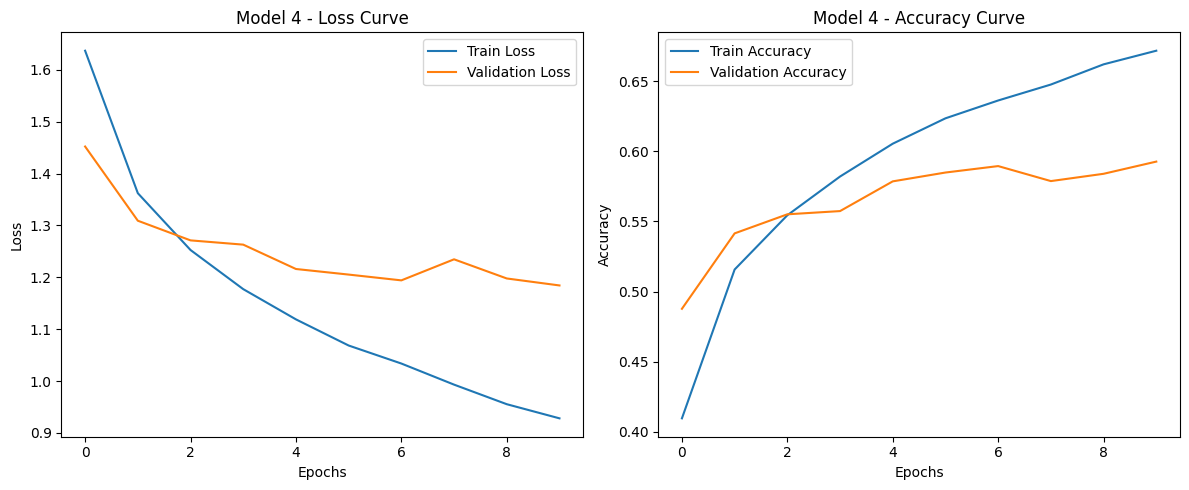

In [9]:

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np


(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)


# Model 1
print("\nBuilding and training Model 1...")
model1 = Sequential([
    Conv2D(2, (3, 3), activation='relu', input_shape=(32, 32, 3), padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(4, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

model1.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

print("\nModel 1 Summary:")
model1.summary()

history1 = model1.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    verbose=1
)

loss1, accuracy1 = model1.evaluate(X_test, y_test, verbose=0)
print(f"Model 1 - Test Loss: {loss1:.4f}, Test Accuracy: {accuracy1:.4f}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model 1 - Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model 1 - Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()


# Model 2
print("\nBuilding and training Model 2...")
model2 = Sequential([
    Conv2D(4, (3, 3), activation='relu', input_shape=(32, 32, 3), padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(8, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

model2.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

print("\nModel 2 Summary:")
model2.summary()

history2 = model2.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    verbose=1
)

loss2, accuracy2 = model2.evaluate(X_test, y_test, verbose=0)
print(f"Model 2 - Test Loss: {loss2:.4f}, Test Accuracy: {accuracy2:.4f}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model 2 - Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model 2 - Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()


# Model 3
print("\nBuilding and training Model 3...")
model3 = Sequential([
    Conv2D(4, (3, 3), activation='relu', input_shape=(32, 32, 3), padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

model3.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

print("\nModel 3 Summary:")
model3.summary()

history3 = model3.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    verbose=1
)

loss3, accuracy3 = model3.evaluate(X_test, y_test, verbose=0)
print(f"Model 3 - Test Loss: {loss3:.4f}, Test Accuracy: {accuracy3:.4f}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history3.history['loss'], label='Train Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model 3 - Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history3.history['accuracy'], label='Train Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model 3 - Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()


# Model 4
print("\nBuilding and training Model 4...")
model4 = Sequential([
    Conv2D(4, (5, 5), activation='relu', input_shape=(32, 32, 3), padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(8, (5, 5), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

model4.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

print("\nModel 4 Summary:")
model4.summary()

history4 = model4.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    verbose=1
)

loss4, accuracy4 = model4.evaluate(X_test, y_test, verbose=0)
print(f"Model 4 - Test Loss: {loss4:.4f}, Test Accuracy: {accuracy4:.4f}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history4.history['loss'], label='Train Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model 4 - Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history4.history['accuracy'], label='Train Accuracy')
plt.plot(history4.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model 4 - Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()